In [1]:
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
import os
import numpy as np
import datetime
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

In [2]:
top_down_path = os.getcwd()
os.chdir("../Data")
data_path = os.getcwd()
os.chdir(top_down_path)

# Read data

In [3]:
# Read preprocessed
df = pd.read_csv(os.path.join(data_path, "preprocessed.csv"), index_col=0)
df.index = pd.to_datetime(df.index)

In [4]:
df[['rlm', 'slp']].mean() * 365 #/ df[['slp', 'rlm']].sum().sum()

rlm    586.975086
slp    408.364157
dtype: float64

In [5]:
df.head().transpose()

,2017-01-01,2017-01-02,2017-01-03,2017-01-04,2017-01-05
slp,2.302289,2.362777,2.284347,2.203892,2.509253
rlm,1.673442,2.056043,2.030095,2.108759,2.358004
industry,1.419512,1.627412,1.676475,1.745934,1.762829
industry_scaled,1.141035,1.30815,1.347588,1.40342,1.417001
gas_to_electricity_public,0.253931,0.428631,0.35362,0.362826,0.595174
electricity_from_gas,0.139161,0.234902,0.193794,0.198839,0.326173
gas_price [€/MWh],NaN,NaN,NaN,NaN,NaN
producing_sector,91.1,91.1,91.1,91.1,91.1
manufacturing_sector,94.1,94.1,94.1,94.1,94.1
hospitality_sector,82.6,82.6,82.6,82.6,82.6


# Prepare regression data

In [6]:
dfx = df.copy()
dfx = dfx.rename(columns={
    'aggregated': 'w2h',
    'gas_to_electricity_public': 'power',
    'producing_sector': 'prod',
    'manufacturing_sector': 'manu',
    'retail_sector': 'retail',
    'hospitality_sector': 'hosp',
    'gas_price [€/MWh]': 'prices',
    'temperature': 'temp',
    'temperature_inertia': 'temp_inertia',
    'industry_scaled': 'industry_scaled'
})

dfx['log_slp'] = np.log(dfx['slp'])
dfx['log_rlm'] = np.log(dfx['rlm'])
dfx['log_power'] = np.log(dfx['power'])
dfx['log_industry'] = np.log(dfx['industry'])
dfx['power2'] = dfx['power'].apply(lambda x: x**2)

dfx = dfx[
    (dfx.holiday==0) & 
    (dfx.christmas_period==0) & 
    (dfx.bridgeday==0)
]

# Cut December 22-23
dfx = dfx[((dfx.index.month!=12)|(dfx.index.day<22))]

# Cut corona
# covid_beginning = "2020-02-01" --> lockdown started on 13 March 2020
#dfx = dfx[(dfx.index < '2020-03-01')|(dfx.index >= '2021-05-01')]
# invasion_date = "2022-02-24"

In [7]:
def model(dependent_variable, control_list):
    
    m = f'{dependent_variable} ~ 1 + time + C(month) + C(weekday) + ' + ' + '.join(control_list)
    print(m)
    return smf.ols(m, dfx.loc[fitting_start:]).fit(cov_type='HAC', cov_kwds={'maxlags':6})

In [8]:
def all_models(dummy_list, consumer='rlm', further_controls=False, econ=False):
    
    results = {}
    
    names = ['naive', 'temp',]
    if econ:
        names += ['temp+econ']
    if consumer == 'rlm':
        names += ['temp+econ']
    if consumer == 'power':
        names = ['naive']
    
    for name in names:
    
        control_list = [d for d in dummy_list]        
        if 'temp' in name:
            control_list += ['residential','time*residential','solar']
#            control_list += ['residential','commercial','time*residential','solar']
#        if 'temp' in name:
#            control_list += 'w2h','time*w2h','temp,'solar']
        if 'econ' in name:
            control_list += ['manu'] if (consumer=='rlm' or consumer=='industry') else ['hosp','retail']
#            control_list += ['manu','prod'] if (consumer=='rlm' or consumer=='industry') else ['hosp','retail']
        if 'naive' in name:
            #control_list += ['temp','time*temp','solar','time*solar', "temp_inertia"]
            #control_list += ['temp_inertia']
            control_list = control_list
        results[name] = model(f'{"log_" if log else ""}{consumer}', control_list)

    return results

In [9]:
np.corrcoef(dfx['commercial'], dfx['residential']) #very strong correlation between commercial and residential

array([[1.        , 0.99673407],
       [0.99673407, 1.        ]])

In [10]:
np.corrcoef(dfx['manu'], dfx['prod']) #very strong correlation between manu and prod

array([[1.        , 0.97392426],
       [0.97392426, 1.        ]])

In [11]:
np.corrcoef(dfx['hosp'], dfx['retail']) #correlation between hosp and retail is fine

array([[ 1.        , -0.19318314],
       [-0.19318314,  1.        ]])

In [12]:
dfx['time_residential'] = dfx['residential']*dfx['time']
np.corrcoef(dfx['time_residential'], dfx['residential']) #correlation between residential and time*residential is fine

array([[1.        , 0.63987698],
       [0.63987698, 1.        ]])

In [13]:
np.corrcoef(dfx['residential'], dfx['solar']) #correlation between residential and solar is fine

array([[ 1.        , -0.69329581],
       [-0.69329581,  1.        ]])

In [14]:
np.corrcoef(dfx['time'], dfx['solar']) #correlation between manu and solar is fine

array([[ 1.        , -0.05791364],
       [-0.05791364,  1.        ]])

In [15]:
def extract_results(dummy_list, results):
    
    extracted_results = pd.concat(
        [results.params, results.bse], keys=['coef', 'se'], axis=1
    )
    
    extracted_results = extracted_results*100 if log else extracted_results
    extracted_results = extracted_results.loc[[d + '[T.True]' for d in dummy_list]]
    extracted_results.index = dummy_list
    extracted_results['low'] = extracted_results['coef'] - 2 * extracted_results['se']
    extracted_results['high'] = extracted_results['coef'] + 2 * extracted_results['se']
    
    return extracted_results

# One crisis dummy

In [16]:
title_conversion = {
        'slp':'Small consumers',
        'rlm':'Large consumers',
#        'industry_scaled':'Industrial consumers scaled',  
        'industry':'Industrial consumers',  
        'power':'Power sector'  
}

In [17]:
def plot_waterfall(ax, results, consumer='rlm', ylabel=''):

    colors = ['tab:blue', 'tab:orange', 'tab:purple', 'tab:green', 'tab:red']
    
    for i, (name, res) in enumerate(results.items()):
        
        # first bar
        if i==0:
            ax.bar(i, res['coef'], alpha=0.5, color=colors[i])
            ax.plot([i,i], [res['low'], res['high']], color=colors[i])
        
        # waterfall
        if i > 0:
            ax.bar(i, res['coef'] - previous_coef, bottom=previous_coef, alpha=0.5, color=colors[i])    
            ax.plot([i-1.4,i+0.4], [previous_coef, previous_coef], color='black', linewidth=0.7, linestyle='--')
            ax.plot([i-0.4,i+1.4], [res['coef'], res['coef']], color='black', linewidth=0.7, linestyle='--')
            
        previous_coef = res['coef']
    
    # last bar
    if consumer != "power":
        i += 1
        ax.bar(i, res['coef'], alpha=0.5, color=colors[-1])
        ax.plot([i,i], [res['low'], res['high']], color=colors[-1])

    ax.grid(axis='y')
    ax.axhline(0, color='black', linewidth=0.5)
    ax.set_ylabel(ylabel)
    ax.set_title(title_conversion[consumer])    
    if log:
        ax.set_ylim(-21, 7)
        
    labels = ['Overall\nchange', 'Temperature']
    if 'temp+econ' in results.keys():
        labels += ['Economic\nactivity']
    if consumer=='rlm': 
        labels += ['Power\nsector']
    if consumer=='power': 
        labels = ['Overall\nchange']
    ax.set_xticks(range(len(results)) if consumer == "power" else range(len(results)+1))
    ax.set_xticklabels(labels if consumer == "power" else (labels + ['Crisis\nresponse']))

In [18]:
def one_dummy(further_controls=False, econ=False):
    
    dummy_list=['crisis']
    dfx['crisis'] = dfx.index.map(lambda x: x >= crisis_start)

    results = {
        consumer: all_models(dummy_list, consumer, further_controls=further_controls, econ=econ) 
 #       for consumer in ['slp', 'industry_scaled', 'power']
        for consumer in ['slp', 'industry', 'power']

    }
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4.5), sharey='row', gridspec_kw={'width_ratios': [1,1,0.4]})

    res = {m: extract_results(dummy_list, value) for m, value in results['slp'].items()}
    ax1 = plot_waterfall(ax1, res, 'slp', 'Estimated change in demand ' + ('(%)' if log else '(TWh/d)'))

    res = {m: extract_results(dummy_list, value) for m, value in results['industry'].items()}
#    res = {m: extract_results(dummy_list, value) for m, value in results['industry_scaled'].items()}
    ax2 = plot_waterfall(ax2, res, 'industry')
#    ax2 = plot_waterfall(ax2, res, 'industry_scaled')
    
    res = {m: extract_results(dummy_list, value) for m, value in results['power'].items()}
    ax3 = plot_waterfall(ax3, res, 'power')

    plt.tight_layout()
    
    return results

## Main Specification

slp ~ 1 + time + C(month) + C(weekday) + crisis
slp ~ 1 + time + C(month) + C(weekday) + crisis + residential + time*residential + solar
slp ~ 1 + time + C(month) + C(weekday) + crisis + residential + time*residential + solar + hosp + retail
industry ~ 1 + time + C(month) + C(weekday) + crisis
industry ~ 1 + time + C(month) + C(weekday) + crisis + residential + time*residential + solar
industry ~ 1 + time + C(month) + C(weekday) + crisis + residential + time*residential + solar + manu
power ~ 1 + time + C(month) + C(weekday) + crisis


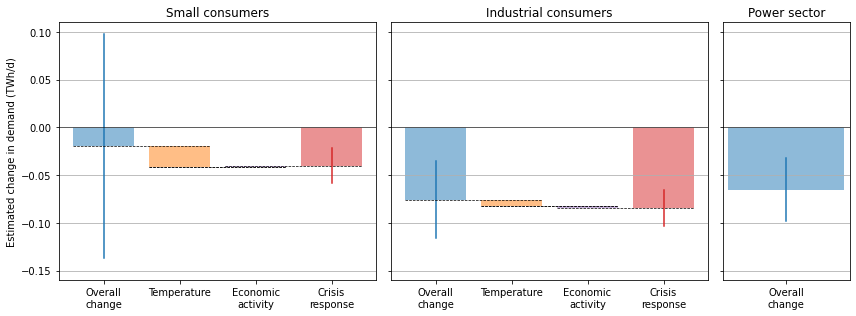

In [19]:
log=False
fitting_start = "2017-01-01"
crisis_start = "2021-08-01"
results = one_dummy(econ=True)
plt.ylim(-.16, .11)
plt.savefig(f'one_dummy.png', dpi=300)

In [20]:
#results['industry']['temp+econ'].summary()
results['slp']['temp+econ'].summary()
#results['power']['naive'].summary()

C:\Users\c.stiewe\Anaconda3\lib\site-packages\statsmodels\base\model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 24, but rank is 1
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    slp   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     3.892
Date:                Mon, 18 Jul 2022   Prob (F-statistic):             0.0487
Time:                        18:45:31   Log-Likelihood:                 2856.3
No. Observations:                1788   AIC:                            -5663.
Df Residuals:                    1763   BIC:                            -5525.
Df Model:                          24                                         
Covariance Type:                  HAC                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.1713      0.079      2.156      0.031       0.016       0.327
C(month)[T.2]              -0.0024      0.011     -0.231      0.817      -0.023       0.018
C(month)[T.3]              -0.0726      0.016     -4.561      0.000      -0.104      -0.041
C(month)[T.4]              -0.1660      0.016    -10.354      0.000      -0.197      -0.135
C(month)[T.5]              -0.1972      0.019    -10.431      0.000      -0.234      -0.160
C(month)[T.6]              -0.1767      0.020     -8.638      0.000      -0.217      -0.137
C(month)[T.7]              -0.1790      0.020     -8.829      0.000      -0.219      -0.139
C(month)[T.8]              -0.1779      0.019     -9.457      0.000      -0.215      -0.141
C(month)[T.9]              -0.1931      0.019    -10.198      0.000      -0.230      -0.156
C(month)[T.10]             -0.1601      0.018     -9.021      0.000      -0.195      -0.125
C(month)[T.11]             -0.0883      0.020     -4.463      0.000      -0.127      -0.050
C(month)[T.12]             -0.0086      0.024     -0.351      0.726      -0.056       0.039
C(weekday)[T.Monday]        0.0013      0.004      0.350      0.726      -0.006       0.008
C(weekday)[T.Saturday]     -0.0265      0.003     -9.415      0.000      -0.032      -0.021
C(weekday)[T.Sunday]       -0.0214      0.004     -5.985      0.000      -0.028      -0.014
C(weekday)[T.Thursday]      0.0053      0.003      1.990      0.047    7.85e-05       0.010
C(weekday)[T.Tuesday]       0.0022      0.004      0.577      0.564      -0.005       0.010
C(weekday)[T.Wednesday]    -0.0002      0.003     -0.066      0.948      -0.007       0.006
crisis[T.True]             -0.0401      0.009     -4.394      0.000      -0.058      -0.022
time                      1.53e-05   1.15e-05      1.331      0.183   -7.24e-06    3.78e-05
residential                 1.4354      0.013    111.823      0.000       1.410       1.461
time:residential         4.933e-05   8.52e-06      5.790      0.000    3.26e-05     6.6e-05
solar                    7.898e+07      4e+07      1.973      0.049     5.1e+05    1.57e+08
hosp                    -6.708e-05      0.000     -0.451      0.652      -0.000       0.000
retail                     -0.0006      0.001     -0.752      0.452      -0.002       0.001
==============================================================================
Omnibus:                       29.803   Durbin-Watson:                   0.571
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               55.673
Skew:                           0.038   Prob(JB):                     8.14e-13
Kurtosis:                       3.861   Cond. No.                     3.89e+13
==============================================================================

Notes:
[1] Standard Errors are h

In [21]:
# year-on-year
for con, mod  in [('industry','temp+econ'),('slp','temp+econ'),('power','naive')]:
    
    crisis_coefficient = -results[con][mod].params["crisis[T.True]"]
    ref = dfx[(dfx.index >= '2020-08-01') & (dfx.index < '2021-05-01')][con].mean()  #, (338+58)/(338+141+58))
    print(
          title_conversion[con] + ": " + str(round(crisis_coefficient,4)) + " TWh/d " + "\n" +"which is " + str(round(100*crisis_coefficient/ ref)) +" % of "+ str(round(ref,4)) + " TWh/d avg. demand during months 8-3 before crisis"+ "\n" 
         )

Industrial consumers: 0.0843 TWh/d 
which is 6 % of 1.3404 TWh/d avg. demand during months 8-3 before crisis

Small consumers: 0.0401 TWh/d 
which is 3 % of 1.386 TWh/d avg. demand during months 8-3 before crisis

Power sector: 0.0651 TWh/d 
which is 14 % of 0.4624 TWh/d avg. demand during months 8-3 before crisis



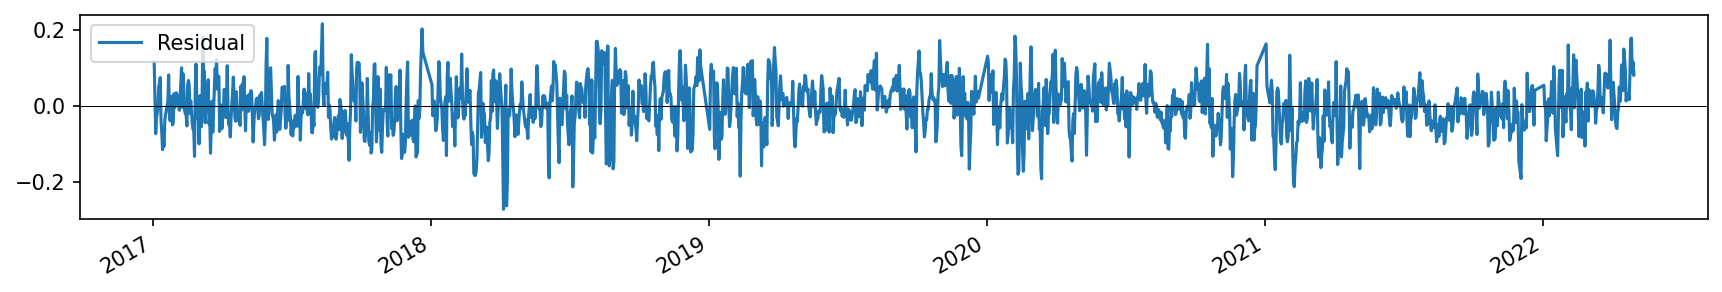

In [22]:
resid = results['industry']['temp+econ'].fittedvalues - dfx['industry'] 

plt.figure(figsize=(14, 2), dpi=150)
#results['rlm']['temp+power+econ'].fittedvalues.plot(label='Fitted')
#dfx['rlm'].plot(label='Observed')
resid.plot(label='Residual')
plt.axhline(0, color='black', linewidth=0.5)
plt.legend(loc='upper left')

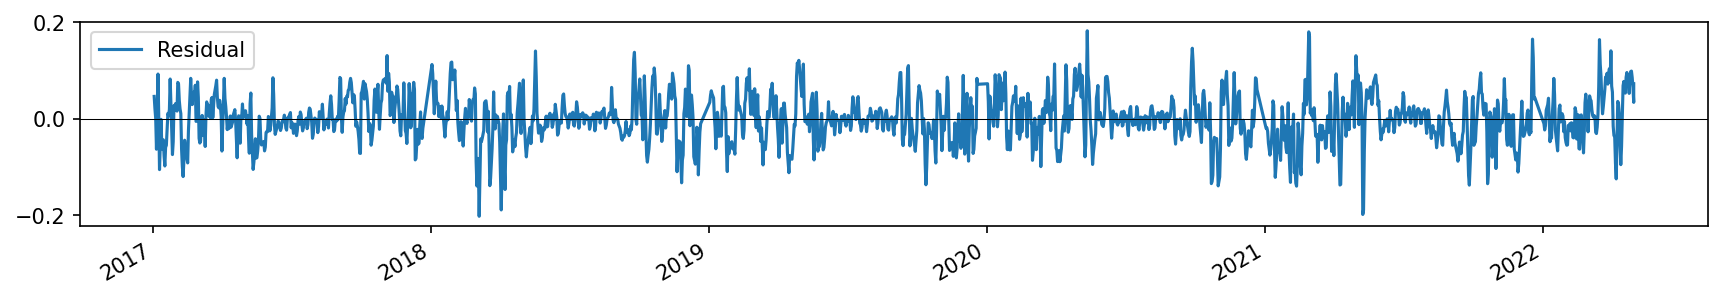

In [23]:
resid = results['slp']['temp+econ'].fittedvalues - dfx['slp'] 

plt.figure(figsize=(14, 2), dpi=150)
#results['slp']['temp+econ'].fittedvalues.plot(label='Fitted')
#dfx['slp'].plot(label='Observed')
resid.plot(label='Residual')
plt.axhline(0, color='black', linewidth=0.5)
plt.legend()

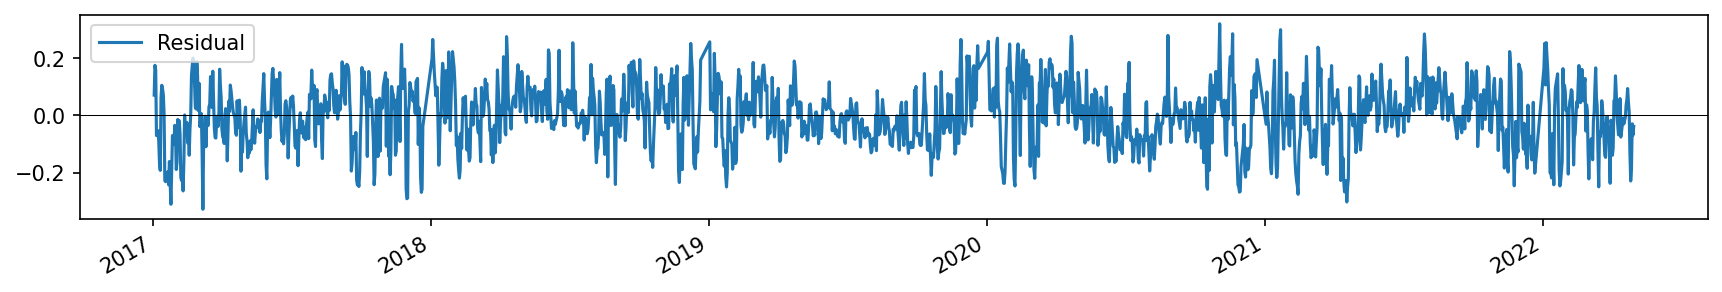

In [24]:
resid = results['power']['naive'].fittedvalues - dfx['power'] 

plt.figure(figsize=(14, 2), dpi=150)

resid.plot(label='Residual')
plt.axhline(0, color='black', linewidth=0.5)
plt.legend()

## Sensitivities

Crisis start: 1-2 month later crisis start does not change a lot, but including June-July significantly reduces average response of small & industrial consumers

slp ~ 1 + time + C(month) + C(weekday) + crisis
slp ~ 1 + time + C(month) + C(weekday) + crisis + residential + time*residential + solar
slp ~ 1 + time + C(month) + C(weekday) + crisis + residential + time*residential + solar + hosp + retail
industry ~ 1 + time + C(month) + C(weekday) + crisis
industry ~ 1 + time + C(month) + C(weekday) + crisis + residential + time*residential + solar
industry ~ 1 + time + C(month) + C(weekday) + crisis + residential + time*residential + solar + manu
power ~ 1 + time + C(month) + C(weekday) + crisis


(-0.21, 0.11)

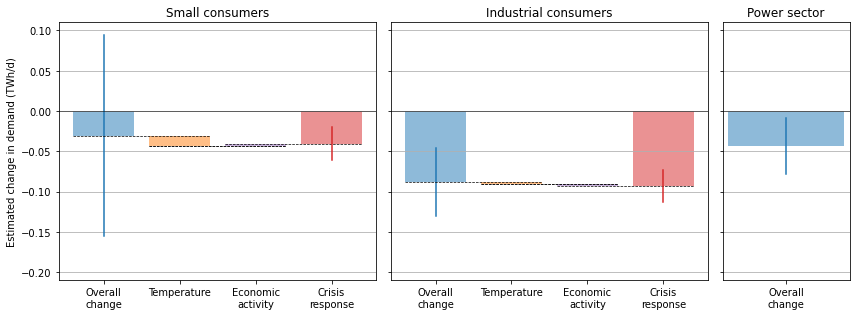

In [25]:
log=False
fitting_start = "2017-01-01"
crisis_start = "2021-09-01" #default: 2021-08-01
results = one_dummy(econ=True)
plt.ylim(-.21, .11)

slp ~ 1 + time + C(month) + C(weekday) + crisis
slp ~ 1 + time + C(month) + C(weekday) + crisis + residential + time*residential + solar
slp ~ 1 + time + C(month) + C(weekday) + crisis + residential + time*residential + solar + hosp + retail
industry ~ 1 + time + C(month) + C(weekday) + crisis
industry ~ 1 + time + C(month) + C(weekday) + crisis + residential + time*residential + solar
industry ~ 1 + time + C(month) + C(weekday) + crisis + residential + time*residential + solar + manu
power ~ 1 + time + C(month) + C(weekday) + crisis


(-0.21, 0.11)

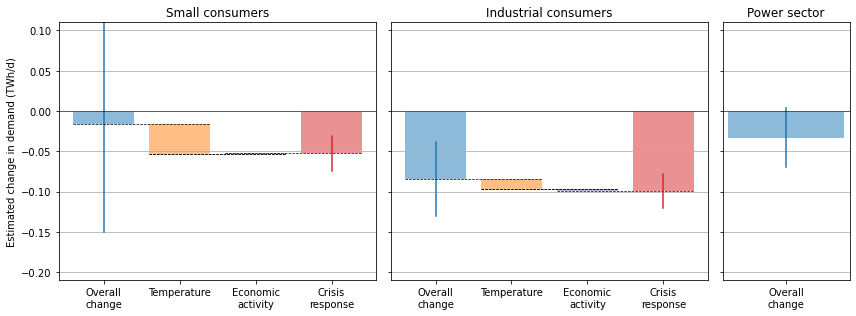

In [26]:
log=False
fitting_start = "2017-01-01"
crisis_start = "2021-10-01" #default: 2021-08-01
results = one_dummy(econ=True)
plt.ylim(-.21, .11)

slp ~ 1 + time + C(month) + C(weekday) + crisis
slp ~ 1 + time + C(month) + C(weekday) + crisis + residential + time*residential + solar
slp ~ 1 + time + C(month) + C(weekday) + crisis + residential + time*residential + solar + hosp + retail
industry ~ 1 + time + C(month) + C(weekday) + crisis
industry ~ 1 + time + C(month) + C(weekday) + crisis + residential + time*residential + solar
industry ~ 1 + time + C(month) + C(weekday) + crisis + residential + time*residential + solar + manu
power ~ 1 + time + C(month) + C(weekday) + crisis


(-0.21, 0.11)

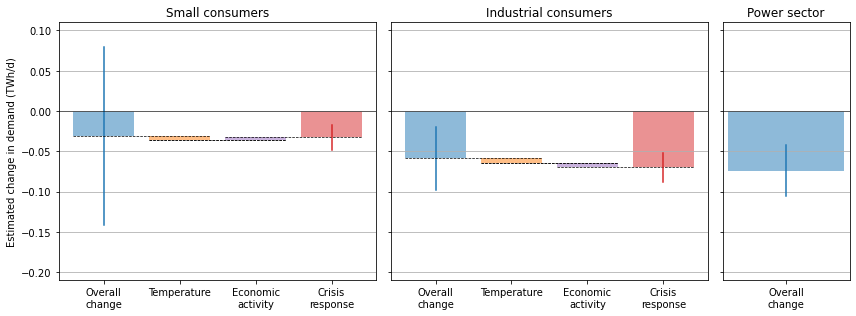

In [27]:
log=False
fitting_start = "2017-01-01"
crisis_start = "2021-06-01" #default: 2021-08-01
results = one_dummy(econ=True)
plt.ylim(-.21, .11)

Fitting period: Quite sensitive to change in fitting period, crisis response of industrial consumers increases with reduced fitting period while small consumers' response is rather stable

slp ~ 1 + time + C(month) + C(weekday) + crisis
slp ~ 1 + time + C(month) + C(weekday) + crisis + residential + time*residential + solar
slp ~ 1 + time + C(month) + C(weekday) + crisis + residential + time*residential + solar + hosp + retail
industry ~ 1 + time + C(month) + C(weekday) + crisis
industry ~ 1 + time + C(month) + C(weekday) + crisis + residential + time*residential + solar
industry ~ 1 + time + C(month) + C(weekday) + crisis + residential + time*residential + solar + manu
power ~ 1 + time + C(month) + C(weekday) + crisis


(-0.21, 0.11)

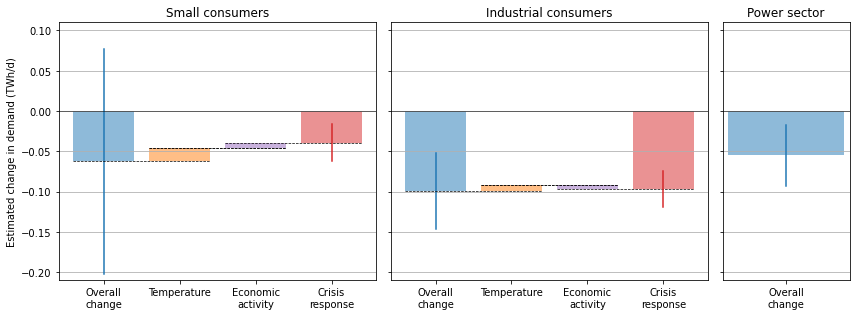

In [28]:
log=False
fitting_start = "2018-01-01" #default: 2017-01-01
crisis_start = "2021-09-01" 
results = one_dummy(econ=True)
plt.ylim(-.21, .11)

slp ~ 1 + time + C(month) + C(weekday) + crisis
slp ~ 1 + time + C(month) + C(weekday) + crisis + residential + time*residential + solar
slp ~ 1 + time + C(month) + C(weekday) + crisis + residential + time*residential + solar + hosp + retail
industry ~ 1 + time + C(month) + C(weekday) + crisis
industry ~ 1 + time + C(month) + C(weekday) + crisis + residential + time*residential + solar
industry ~ 1 + time + C(month) + C(weekday) + crisis + residential + time*residential + solar + manu
power ~ 1 + time + C(month) + C(weekday) + crisis


(-0.21, 0.11)

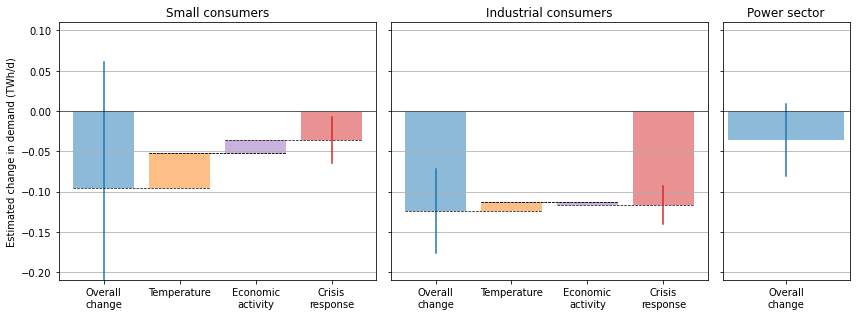

In [29]:
log=False
fitting_start = "2019-01-01" #default: 2017-01-01
crisis_start = "2021-09-01" 
results = one_dummy(econ=True)
plt.ylim(-.21, .11)

slp ~ 1 + time + C(month) + C(weekday) + crisis
slp ~ 1 + time + C(month) + C(weekday) + crisis + residential + time*residential + solar
slp ~ 1 + time + C(month) + C(weekday) + crisis + residential + time*residential + solar + hosp + retail
industry ~ 1 + time + C(month) + C(weekday) + crisis
industry ~ 1 + time + C(month) + C(weekday) + crisis + residential + time*residential + solar
industry ~ 1 + time + C(month) + C(weekday) + crisis + residential + time*residential + solar + manu
power ~ 1 + time + C(month) + C(weekday) + crisis


(-0.25, 0.11)

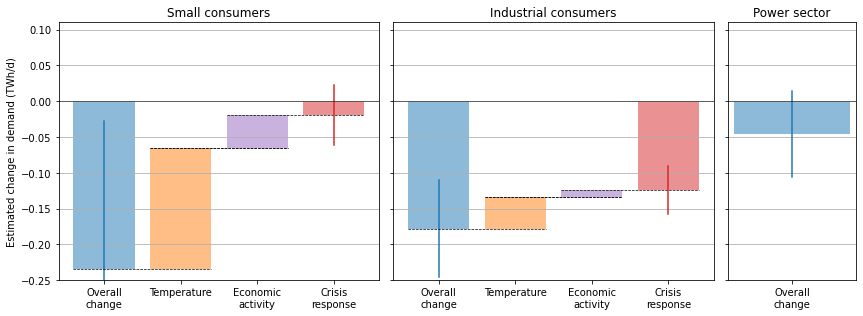

In [30]:
log=False
fitting_start = "2020-01-01" #default: 2017-01-01
crisis_start = "2021-09-01" 
results = one_dummy(econ=True)
plt.ylim(-.25, .11)

Add/remove control variables: Omitting economic activity does not change a lot

slp ~ 1 + time + C(month) + C(weekday) + crisis
slp ~ 1 + time + C(month) + C(weekday) + crisis + residential + time*residential + solar
industry ~ 1 + time + C(month) + C(weekday) + crisis
industry ~ 1 + time + C(month) + C(weekday) + crisis + residential + time*residential + solar
power ~ 1 + time + C(month) + C(weekday) + crisis


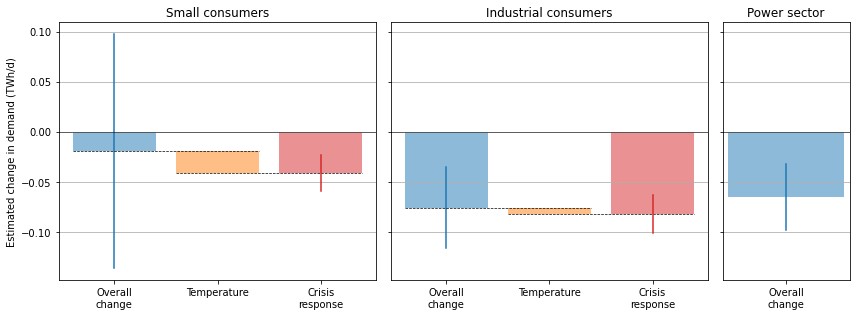

In [31]:
log=False
fitting_start = "2017-01-01"
crisis_start = "2021-08-01"
results = one_dummy(econ=False)

# Quarterly dummies (not currently used)

In [32]:
mode = 'quarterly'
crisis_start = "2021-09-01"
dummy_list = []
for date in pd.date_range(crisis_start, '2022-04', freq='3m'):
    dummy_name = f'd{date.year}_{date.quarter}'
    dfx[dummy_name] = dfx.index.map( 
        lambda x: (x.year==date.year) & (x.quarter==date.quarter)
    ).values
    dummy_list.append(dummy_name)

# Monthly dummies

In [33]:
mode = 'monthly'
crisis_start = "2021-05-01"
dummy_list = []
for date in pd.date_range(crisis_start, '2022-05', freq='1m'):
    dummy_name = f'd{date.year}_{date.month}'
    dfx[dummy_name] = dfx.index.map(   
        lambda x: (x.year==date.year) & (x.month==date.month)
    ).values
    dummy_list.append(dummy_name)

In [34]:
def plot_monthly(ax, results, consumer='industry', ylabel='Crisis response (TWh/d)', names=None):

    colors = {
        'naive': 'tab:blue',
        'temp+econ': ('tab:orange' if consumer=='industry' else 'tab:red'),
        'power': 'tab:green'
    }
    extracted_results = {m: extract_results(dummy_list, value) for m, value in results[consumer].items()}
    
    if names==None:
        names = extracted_results.keys()
    
    for i, name in enumerate(names):
        
        res = extracted_results[name]
        
        idx = [j-0.15*(len(names)-1)+0.6/len(names)*i for j in range(len(res))]
        ax.bar(idx, res['coef'], width=0.6/len(names),alpha=0.5, label=name, color=colors[name])
        for j, d in enumerate(dummy_list):
            ax.plot([idx[j], idx[j]], [res.loc[d, 'low'], res.loc[d, 'high']], 
                     color=colors[name])
    ax.grid(axis='y')
    ax.axhline(0, color='black', linewidth=0.5)
    ax.set_ylabel(ylabel)
    ax.set_ylim(-0.21, 0.1)
    title_conversion = {
        'slp':'Small consumers',
        'rlm':'Large consumers',
        'industry':'Industrial consumers',
        'power': "Power sector"
    }
    ax.set_title(title_conversion[consumer])
   
    ax.set_xticks(
        range(len(res)), 
    #    [f'{date.month_name()[:3]}'+(f'\n{date.year}' if ((date.month==1) | (i==0)) else '')
    #     for i, date in enumerate(pd.date_range(crisis_start, '2022-05', freq='1m'))]
    )
    ax.set_xticklabels(
        [f'{date.month_name()[:3]}'+(f'\n{date.year}' if ((date.month==1) | (i==0)) else '')
         for i, date in enumerate(pd.date_range(crisis_start, '2022-05', freq='1m'))]
    )
    
    ax.axvline(7.5, color='black', linewidth=0.5)

In [35]:
log=False
results = {consumer: all_models(dummy_list, consumer, econ=True) for consumer in ['slp', 'industry', 'power']}

slp ~ 1 + time + C(month) + C(weekday) + d2021_5 + d2021_6 + d2021_7 + d2021_8 + d2021_9 + d2021_10 + d2021_11 + d2021_12 + d2022_1 + d2022_2 + d2022_3 + d2022_4
slp ~ 1 + time + C(month) + C(weekday) + d2021_5 + d2021_6 + d2021_7 + d2021_8 + d2021_9 + d2021_10 + d2021_11 + d2021_12 + d2022_1 + d2022_2 + d2022_3 + d2022_4 + residential + time*residential + solar
slp ~ 1 + time + C(month) + C(weekday) + d2021_5 + d2021_6 + d2021_7 + d2021_8 + d2021_9 + d2021_10 + d2021_11 + d2021_12 + d2022_1 + d2022_2 + d2022_3 + d2022_4 + residential + time*residential + solar + hosp + retail
industry ~ 1 + time + C(month) + C(weekday) + d2021_5 + d2021_6 + d2021_7 + d2021_8 + d2021_9 + d2021_10 + d2021_11 + d2021_12 + d2022_1 + d2022_2 + d2022_3 + d2022_4
industry ~ 1 + time + C(month) + C(weekday) + d2021_5 + d2021_6 + d2021_7 + d2021_8 + d2021_9 + d2021_10 + d2021_11 + d2021_12 + d2022_1 + d2022_2 + d2022_3 + d2022_4 + residential + time*residential + solar
industry ~ 1 + time + C(month) + C(weekda

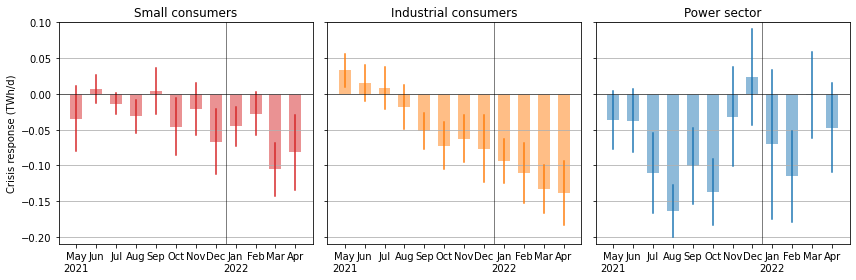

In [36]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4), sharey='row', gridspec_kw={'width_ratios': [1,1,1]})

plot_monthly(ax1, results, 'slp', names=['temp+econ'])
#ax1.text(10.5, 0.02, 'Invasion\nof Ukraine', horizontalalignment='center')

plot_monthly(ax2, results, names=['temp+econ'], ylabel='')
#ax2.text(4.5, 0.02, 'TTF prices\nall-time-high', horizontalalignment='center')

plot_monthly(ax3, results, "power", names=['naive'], ylabel='')
#ax2.text(4.5, 0.02, 'TTF prices\nall-time-high', horizontalalignment='center')

plt.tight_layout()
plt.savefig('months.png')

In [37]:
results['industry']['temp+econ'].summary()
#results['power']['naive'].summary()

C:\Users\c.stiewe\Anaconda3\lib\site-packages\statsmodels\base\model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 34, but rank is 1
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               industry   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.944
Method:                 Least Squares   F-statistic:                     19.72
Date:                Mon, 18 Jul 2022   Prob (F-statistic):           9.52e-06
Time:                        18:45:41   Log-Likelihood:                 2383.4
No. Observations:                1788   AIC:                            -4697.
Df Residuals:                    1753   BIC:                            -4505.
Df Model:                          34                                         
Covariance Type:                  HAC                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.9238      0.056     16.618      0.000       0.815       1.033
C(month)[T.2]              -0.0174      0.013     -1.300      0.193      -0.044       0.009
C(month)[T.3]              -0.0804      0.015     -5.440      0.000      -0.109      -0.051
C(month)[T.4]              -0.1203      0.015     -7.845      0.000      -0.150      -0.090
C(month)[T.5]              -0.1260      0.017     -7.434      0.000      -0.159      -0.093
C(month)[T.6]              -0.1213      0.020     -6.094      0.000      -0.160      -0.082
C(month)[T.7]              -0.1420      0.019     -7.309      0.000      -0.180      -0.104
C(month)[T.8]              -0.1556      0.023     -6.872      0.000      -0.200      -0.111
C(month)[T.9]              -0.1290      0.018     -7.058      0.000      -0.165      -0.093
C(month)[T.10]             -0.0812      0.017     -4.895      0.000      -0.114      -0.049
C(month)[T.11]             -0.0632      0.015     -4.227      0.000      -0.093      -0.034
C(month)[T.12]             -0.0374      0.016     -2.371      0.018      -0.068      -0.006
C(weekday)[T.Monday]        0.0619      0.006     10.919      0.000       0.051       0.073
C(weekday)[T.Saturday]     -0.1220      0.004    -27.203      0.000      -0.131      -0.113
C(weekday)[T.Sunday]       -0.0801      0.005    -15.784      0.000      -0.090      -0.070
C(weekday)[T.Thursday]      0.0464      0.004     10.782      0.000       0.038       0.055
C(weekday)[T.Tuesday]       0.0476      0.006      8.080      0.000       0.036       0.059
C(weekday)[T.Wednesday]     0.0513      0.005      9.760      0.000       0.041       0.062
d2021_5[T.True]             0.0329      0.011      2.888      0.004       0.011       0.055
d2021_6[T.True]             0.0152      0.012      1.225      0.220      -0.009       0.039
d2021_7[T.True]             0.0081      0.015      0.554      0.579      -0.021       0.037
d2021_8[T.True]            -0.0180      0.015     -1.177      0.239      -0.048       0.012
d2021_9[T.True]            -0.0514      0.012     -4.143      0.000      -0.076      -0.027
d2021_10[T.True]           -0.0725      0.017     -4.385      0.000      -0.105      -0.040
d2021_11[T.True]           -0.0623      0.016     -3.796      0.000      -0.095      -0.030
d2021_12[T.True]           -0.0763      0.023     -3.280      0.001      -0.122      -0.031
d2022_1[T.True]            -0.0938      0.016     -6.010      0.000      -0.124      -0.063
d2022_2[T.True]            -0.1107      0.021     -5.245      0.000      -0.152      -0.069
d2022_3[T.True]            -0.1332      0.017     -8.020      0.000      -0.166      -0.101
d2022_4[T.True]            -0.1383      0.022     -6.201      0.000      -0.182      -0.095
time                     9.078e-06    1.2e-05  

In [38]:
log=True
results = {consumer: all_models(dummy_list, consumer, econ=True) for consumer in ['slp', 'industry']}

log_slp ~ 1 + time + C(month) + C(weekday) + d2021_5 + d2021_6 + d2021_7 + d2021_8 + d2021_9 + d2021_10 + d2021_11 + d2021_12 + d2022_1 + d2022_2 + d2022_3 + d2022_4
log_slp ~ 1 + time + C(month) + C(weekday) + d2021_5 + d2021_6 + d2021_7 + d2021_8 + d2021_9 + d2021_10 + d2021_11 + d2021_12 + d2022_1 + d2022_2 + d2022_3 + d2022_4 + residential + time*residential + solar
log_slp ~ 1 + time + C(month) + C(weekday) + d2021_5 + d2021_6 + d2021_7 + d2021_8 + d2021_9 + d2021_10 + d2021_11 + d2021_12 + d2022_1 + d2022_2 + d2022_3 + d2022_4 + residential + time*residential + solar + hosp + retail
log_industry ~ 1 + time + C(month) + C(weekday) + d2021_5 + d2021_6 + d2021_7 + d2021_8 + d2021_9 + d2021_10 + d2021_11 + d2021_12 + d2022_1 + d2022_2 + d2022_3 + d2022_4
log_industry ~ 1 + time + C(month) + C(weekday) + d2021_5 + d2021_6 + d2021_7 + d2021_8 + d2021_9 + d2021_10 + d2021_11 + d2021_12 + d2022_1 + d2022_2 + d2022_3 + d2022_4 + residential + time*residential + solar
log_industry ~ 1 + ti

In [39]:
results['industry']['temp+econ'].summary()

C:\Users\c.stiewe\Anaconda3\lib\site-packages\statsmodels\base\model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 34, but rank is 1
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           log_industry   R-squared:                       0.942
Model:                            OLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                     43.77
Date:                Mon, 18 Jul 2022   Prob (F-statistic):           4.90e-11
Time:                        18:45:42   Log-Likelihood:                 2699.8
No. Observations:                1788   AIC:                            -5330.
Df Residuals:                    1753   BIC:                            -5137.
Df Model:                          34                                         
Covariance Type:                  HAC                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -0.0454      0.046     -0.996      0.319      -0.135       0.044
C(month)[T.2]              -0.0049      0.008     -0.611      0.541      -0.020       0.011
C(month)[T.3]              -0.0378      0.011     -3.420      0.001      -0.059      -0.016
C(month)[T.4]              -0.0668      0.012     -5.691      0.000      -0.090      -0.044
C(month)[T.5]              -0.0861      0.013     -6.661      0.000      -0.111      -0.061
C(month)[T.6]              -0.1035      0.015     -6.789      0.000      -0.133      -0.074
C(month)[T.7]              -0.1263      0.015     -8.434      0.000      -0.156      -0.097
C(month)[T.8]              -0.1474      0.019     -7.810      0.000      -0.184      -0.110
C(month)[T.9]              -0.1004      0.014     -7.099      0.000      -0.128      -0.073
C(month)[T.10]             -0.0478      0.012     -4.056      0.000      -0.071      -0.025
C(month)[T.11]             -0.0338      0.011     -3.070      0.002      -0.055      -0.012
C(month)[T.12]             -0.0186      0.011     -1.697      0.090      -0.040       0.003
C(weekday)[T.Monday]        0.0508      0.005     10.723      0.000       0.042       0.060
C(weekday)[T.Saturday]     -0.1055      0.004    -29.046      0.000      -0.113      -0.098
C(weekday)[T.Sunday]       -0.0685      0.004    -15.886      0.000      -0.077      -0.060
C(weekday)[T.Thursday]      0.0386      0.004     10.620      0.000       0.031       0.046
C(weekday)[T.Tuesday]       0.0396      0.005      8.004      0.000       0.030       0.049
C(weekday)[T.Wednesday]     0.0440      0.004     10.007      0.000       0.035       0.053
d2021_5[T.True]             0.0413      0.011      3.831      0.000       0.020       0.063
d2021_6[T.True]             0.0162      0.012      1.336      0.181      -0.008       0.040
d2021_7[T.True]             0.0077      0.015      0.499      0.618      -0.022       0.038
d2021_8[T.True]            -0.0081      0.016     -0.514      0.607      -0.039       0.023
d2021_9[T.True]            -0.0566      0.014     -4.045      0.000      -0.084      -0.029
d2021_10[T.True]           -0.0554      0.014     -3.831      0.000      -0.084      -0.027
d2021_11[T.True]           -0.0475      0.011     -4.254      0.000      -0.069      -0.026
d2021_12[T.True]           -0.0579      0.015     -3.784      0.000      -0.088      -0.028
d2022_1[T.True]            -0.0617      0.010     -6.103      0.000      -0.081      -0.042
d2022_2[T.True]            -0.0725      0.014     -5.098      0.000      -0.100      -0.045
d2022_3[T.True]            -0.1001      0.014     -7.341      0.000      -0.127      -0.073
d2022_4[T.True]            -0.1181      0.023     -5.140      0.000      -0.163      -0.073
time                     8.916e-06   1.05e-05  

In [40]:
#to calculate elasticities in annex

extracted_results = pd.DataFrame()

for consumer in ['industry','slp']:
    extracted_results[consumer] = results[consumer]['temp+econ'].params
    extracted_results = extracted_results.loc[[d + '[T.True]' for d in dummy_list]]
                 
extracted_results.index = dummy_list
extracted_results

,industry,slp
d2021_5,0.041349,0.160894
d2021_6,0.016219,-0.101995
d2021_7,0.007659,-0.073733
d2021_8,-0.008122,0.150013
d2021_9,-0.056599,-0.101013
d2021_10,-0.055360,0.015845
d2021_11,-0.047464,-0.058389
d2021_12,-0.057906,-0.084501
d2022_1,-0.061684,0.006359
d2022_2,-0.072526,0.034456
